# Tarea 1 Máquinas de Aprendizaje

## Ejercicio 1

a) Construcción del dataframe. La primera columna del dataframe original es redundante para la indexación, mientras que la columna $Train$ nos permite identificar cuales ejemplos serán parte del training set ($Train = T$) y del testing set ($Train = F$). Para explicitar qué ejemplos son del testing set se invierten los valores de verdad de dicha columna. Finalmente la columna ya utilizada se descarta para quedarnos con las columnas de predictores.

In [15]:
import numpy as np
import pandas as pd

url = 'http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/prostate.data'
df = pd.read_csv(url, sep='\t', header=0)
# Remover columna con indices redundantes
df = df.drop('Unnamed: 0', axis=1)
# Obtener columna con la etiqueta Train y reemplazar valores booleanos. Estos ejemplos seran de entrenamiento
istrain_str = df['train']
istrain = np.asarray([True if s == 'T' else False for s in istrain_str])
# Listar como testing el resto de valores falsos de la columna anterior
istest = np.logical_not(istrain)
# Una vez procesado los datos, eliminar la columna train para almacenar los predictores relevantes
df = df.drop('train', axis=1)

b) Descripción del dataset. El dataset posee 9 atributos y 97 samples con valores enteros y reales.

In [16]:
df.shape
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 9 columns):
lcavol     97 non-null float64
lweight    97 non-null float64
age        97 non-null int64
lbph       97 non-null float64
svi        97 non-null int64
lcp        97 non-null float64
gleason    97 non-null int64
pgg45      97 non-null int64
lpsa       97 non-null float64
dtypes: float64(5), int64(4)
memory usage: 6.9 KB


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,1.350010,3.628943,63.865979,0.100356,0.216495,-0.179366,6.752577,24.381443,2.478387
std,1.178625,0.428411,7.445117,1.450807,0.413995,1.398250,0.722134,28.204035,1.154329
min,-1.347074,2.374906,41.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000,-0.430783
25%,0.512824,3.375880,60.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000,1.731656
50%,1.446919,3.623007,65.000000,0.300105,0.000000,-0.798508,7.000000,15.000000,2.591516
75%,2.127041,3.876396,68.000000,1.558145,0.000000,1.178655,7.000000,40.000000,3.056357
max,3.821004,4.780383,79.000000,2.326302,1.000000,2.904165,9.000000,100.000000,5.582932


c) Normalización de datos. Este preprocesamiento de los datos es importante pues las features originales pueden venir en distintas escalas por lo tanto nuestro algoritmo de aprendizaje no funcionará correctamente, por ejemplo al utilizar funciones objetivo que incluyan métricas, los datos con mayor rango tenderán a dominar sobre los de menor rango; por otra parte también podría darse el caso de que la convergencia en algoritmos que usen gradiente descendiente sea lenta o imprecisa.

In [17]:
from sklearn.preprocessing import StandardScaler
# Por defecto centra y escala la data.
scaler = StandardScaler(with_mean=True, with_std=True)
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
#  Deseamos aprender a predecir el feature lpsa, por lo que la recuperamos del original
df_scaled['lpsa'] = df['lpsa']

d) Regresión lineal con Mínimos Cuadrados. En primer lugar extraemos la última columna de los datos, que corresponde al output $y$ de cada ejemplo. La nueva columna añadida corresponde al bias clásico...
El argumento pasado al constructor de LinearRegression indica que no se calculará intercepto para el modelo (ya lo hemos hecho a través de normalizar e ingresar la columna con bias 1)

In [18]:
import sklearn.linear_model as lm
X = df_scaled.ix[:,:-1]
# Agregamos la columna de bias con 1
N = X.shape[0]
X.insert(X.shape[1], 'intercept', np.ones(N))
# Obtener los datos de output conocidos y extraer test & training set
y = df_scaled['lpsa']
Xtrain = X[istrain]
ytrain = y[istrain]
Xtest = X[istest]
ytest = y[istest]
linreg = lm.LinearRegression(fit_intercept=False)
linreg.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

e) Tabla de pesos (coeficientes) y Z-scores para cada variable. Los Z-scores miden el efecto de descartar alguna variable del modelo. Bajo la hipótesis nula de que algún coeficiente debe ser 0, su Z-score entonces se distribuye como una distribución $t_{N-p-1}$. Buscamos en la tabla y vemos que aproximadamente valores superiores a 2 en mayor absoluto

Cuando deseamos un 5% de significancia, las variables que resultarán más importantes deberán tener Z-score en valor abosluto mayor que 2, lo que indica una significancia del 5%. Las variables mas importante spor lo tanto son en orden de Z-score decreciente **lcavol**, **svi**, **lcp** y **pgg45** (falta justificar)

In [19]:
# Correlacion entre variables
# print Xtrain.drop('intercept', axis=1).corr()

# Tabla con coefficientes y sus Z-score
coeffs = linreg.coef_
Table = pd.DataFrame(coeffs, index=X.columns, columns=['Coefficent'])
Table['Std. Error'] = Xtrain.std() / np.sqrt(Xtrain.shape[0])
Table['Z-score'] = Table['Coefficent'].div(Table['Std. Error'], axis=0)
Table

,Coefficent,Std. Error,Z-score
lcavol,0.676016,0.129469,5.221460
lweight,0.261694,0.136618,1.915519
age,-0.140734,0.123746,-1.137281
lbph,0.209061,0.123892,1.687447
svi,0.303623,0.124582,2.437133
lcp,-0.287002,0.123022,-2.332923
gleason,-0.021195,0.120547,-0.175822
pgg45,0.265576,0.127584,2.081583
intercept,2.464933,0.000000,inf


f) Estimación de errores de predicción. El uso de cross validation nos permitirá entender que tan bien generaliza nuestra máquina mientras no tengamos disponible el testing set. La máquina entrenando con 5 folds presenta un MSE (Mean squared error o error cuadrático medio) de 0.95, mientras que con 10 folds el MSE disminuye a 0.75. El MSE en el testing set es finalmente de 0.5 (falta concluir)

In [20]:
# Predecir en el testing set
yhat_test = linreg.predict(Xtest)
# Calcular error cuadrático medio en el testing set
mse_test = np.mean(np.power(yhat_test - ytest, 2))
print "MSE para testing set:", mse_test
from sklearn import cross_validation
Xm = Xtrain.as_matrix()
ym = ytrain.as_matrix()

# Definir numero de folds
n_folds = [5, 10]
# Estimar error con 5 y 10 folds
for nf in n_folds:
    k_fold = cross_validation.KFold(len(Xm), nf)
    # MSE para cross validation
    mse_cv = 0
    for k, (train, val) in enumerate(k_fold):
        linreg = lm.LinearRegression(fit_intercept = False)
        # Modelar con el subconjunto del training set dado por el fold
        linreg.fit(Xm[train], ym[train])
        yhat_val = linreg.predict(Xm[val])
        mse_fold = np.mean(np.power(yhat_val - ym[val], 2))
        mse_cv += mse_fold
    mse_cv = mse_cv / nf
    print "MSE para",nf,"folds:",mse_cv

MSE para testing set: 0.521274005508
MSE para 5 folds: 0.956514631616
MSE para 10 folds: 0.757237472963


j) QQ Plot para error de prueba. Podemos observar que $R^2 = 0.9537$, lo que indica una alta correlación entre los datos de predicción, por lo que es razonable suponer que los residuos se distribuyen de forma normal.

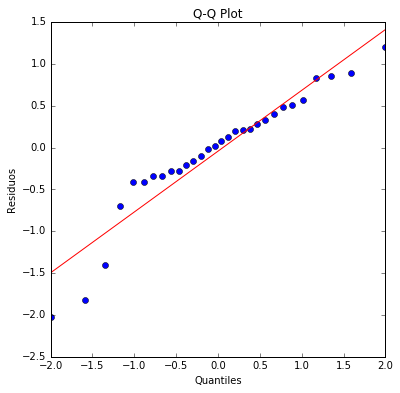

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
residual = yhat_test - ytest
plt.figure(figsize=(6,6))
stats.probplot(residual, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.xlabel("Quantiles")
plt.ylabel("Residuos")
plt.show()

## Ejercicio 2

a) Implementación de FSS. En vez de simplemente usar el error cuadrático medio como criterio para aceptar o no una variable se ha implementado una versión que utiliza el coeficiente $R^2$. Gráficamente los errores de entrenamiento siempre decrecen, pero con 5 variables los errores en el conjunto de test son del orden de 0.45, añadir más variables aumenta el error de test a partir de ese punto

selected = Lcavol ...
totalvars=2, R^2 = 0.537516
selected = Lweight ...
totalvars=3, R^2 = 0.614756
selected = Svi ...
totalvars=4, R^2 = 0.637441
selected = Lbph ...
totalvars=5, R^2 = 0.659176
selected = Pgg45 ...
totalvars=6, R^2 = 0.666920
selected = Lcp ...
totalvars=7, R^2 = 0.682807
selected = Age ...
totalvars=8, R^2 = 0.694258
selected = Gleason ...
totalvars=9, R^2 = 0.694371


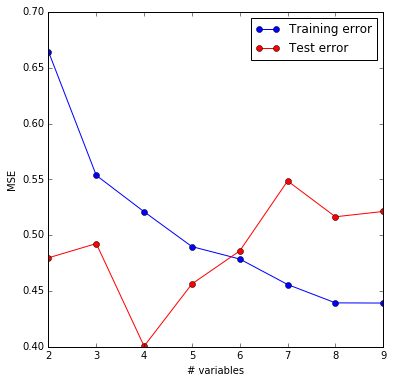

In [22]:
def fss(x, y, x_test, y_test, names_x, k = 10000):
    """
        Forward Step-wise Selection
        Args:
            x: Training set x
            y: Training set y
            x_test: Testing set x
            y_test: Testing set y
            names_x: Labels for training set x
            k: Max number of variables
    """
    # Numero de features
    p = x.shape[1]-1
    k = min(p, k)
    names_x = np.array(names_x)
    remaining = range(0, p)
    # Mantener intercepto
    selected = [p]
    current_score = 0.0
    best_new_score = 0.0
    nvars = []
    training_errors = []
    test_errors = []
    # Mientras hayan candidatos y las variables seleccionadas no superen k
    while remaining and len(selected) <= k:
        score_candidates = []
        # Por cada variable candidata
        for candidate in remaining:
            # Crear un nuevo modelo de regresion
            model = lm.LinearRegression(fit_intercept=False)
            indexes = selected + [candidate]
            # Extraer como conjunto de entrenamiento el intercepto 
            # y los valores asociados a las variables elegidas
            x_train = x[:,indexes]
            # Hacer el fit del modelo y predecir
            model.fit(x_train, y)
            # Predecir sobre training y test
            _x_test = x_test.as_matrix()[:,indexes]
            yhat_train = model.predict(x_train)
            yhat_test = model.predict(_x_test)
            # Obtener residuos y calcular R^2
            residuals_train = yhat_train - y
            residuals_test = yhat_test - y_test
            # Calcular Error de entrenamiento
            training_error = np.mean(np.power(residuals_train,2))
            test_error = np.mean(np.power(residuals_test, 2))
            mean_y = np.mean(y)
            SS_tot = np.sum(np.power(y-mean_y,2))
            SS_res = np.sum(np.power(residuals_train,2))
            R2 = 1 - (SS_res/SS_tot)
            score_candidates.append((R2, candidate, training_error, test_error))
        # Una vez analizadas las candidatas ordenar scores de mayor a menor
        score_candidates.sort()
        # Extraer el elemento de mejor score
        best_new_score, best_candidate, best_training_error, best_test_error= score_candidates.pop()
        # Remover al candidato de la lista de restantes y agregarlo a la lista de seleccionados
        remaining.remove(best_candidate)
        selected.append(best_candidate)
        nvars.append(len(indexes))
        training_errors.append(best_training_error)
        test_errors.append(best_test_error)
        # R^2 correspondiente a esta configuracion para testing set
        print "selected = %s ..."%names_x[best_candidate]
        print "totalvars=%d, R^2 = %f"%(len(indexes),best_new_score)
    return selected, nvars, training_errors, test_errors

names_regressors = ["Lcavol", "Lweight", "Age", "Lbph", "Svi", "Lcp", "Gleason", "Pgg45"]
selected, nvars, training_errors, test_errors = fss(Xm, ym, Xtest, ytest, names_regressors)
plt.figure(figsize=(6,6))
plt.plot(nvars, training_errors, 'bo-', label="Training error")
plt.plot(nvars, test_errors, 'ro-', label="Test error")
plt.legend()
plt.xlabel("# variables")
plt.ylabel("MSE")
plt.show()

## Ejercicio 3

(a) Ajuste un modelo lineal utilizando "Ridge Regression", es decir, regularizando con la norma L2. Utilice valores del parámetro de regularización λ ‡ en el rango [10⁴, 10⁻¹]. Construya un gráfico que muestre los coeficientes obtenidos como función del parámetro de regularización. Describa lo que observa.

In [23]:
X = X.drop('intercept', axis=1)

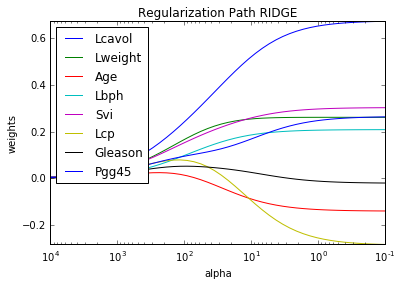

In [24]:
from sklearn.linear_model import Ridge
import matplotlib.pylab as plt

Xtrain = X[istrain]
ytrain = y[istrain]
names_regressors = ["Lcavol", "Lweight", "Age", "Lbph", "Svi", "Lcp", "Gleason", "Pgg45"]
alphas_ = np.logspace(4,-1,base=10)
coefs = []
model = Ridge(fit_intercept=True,solver='svd')

for a in alphas_:
    model.set_params(alpha=a)
    model.fit(Xtrain, ytrain)
    coefs.append(model.coef_)

ax = plt.gca()

for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    plt.plot(alphas_, y_arr, label=label)

plt.legend()
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1]) # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Regularization Path RIDGE')
plt.axis('tight')
plt.legend(loc=2)
plt.show()

Se observa que a mayor alpha el algoritmo es más agresivo en no considerar variables (darles peso 0). El comportamiento se estabiliza, en este caso, en 10⁻¹ (se hizo experimentos con valores menores de alpha y es muy similar el resultado).

(b) Ajuste un modelo lineal utilizando el método "Lasso", es decir, regularizando con la norma L1. Utilice
valores del parámetro de regularización λ § en el rango [10¹ , 10⁻²]. Para obtener el código, modifique las lı́neas 7 y 9 del ejemplo anterior. Construya un gráfico que muestre los coeficientes obtenidos como función del parámetro de regularización. Describa lo que observa. ¿Es más efectivo Lasso para seleccionar atributos?

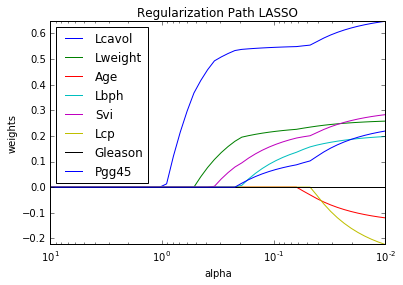

In [25]:
from sklearn.linear_model import Lasso
import matplotlib.pylab as plt

Xtrain = X[istrain]
ytrain = y[istrain]
names_regressors = ["Lcavol", "Lweight", "Age", "Lbph", "Svi", "Lcp", "Gleason", "Pgg45"]
alphas_ = np.logspace(1,-2,base=10)
coefs = []
model = Lasso(fit_intercept=True)

for a in alphas_:
    model.set_params(alpha=a)
    model.fit(Xtrain, ytrain)
    coefs.append(model.coef_)

ax = plt.gca()

for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    plt.plot(alphas_, y_arr, label=label)

plt.legend()
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1]) # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Regularization Path LASSO')
plt.axis('tight')
plt.legend(loc=2)
plt.show()

Con Lasso se anulan las variables de manera más acelerada lo cual logra que la selección del parámetro alpha se comporte, aproximadamente, como la cantidad de variables a anular.

(c) Utilizando "Ridge Regression", construya un gráfico que muestre el error de entrenamiento y el error de pruebas como función del parámetro de regularización. Discuta lo que observa.

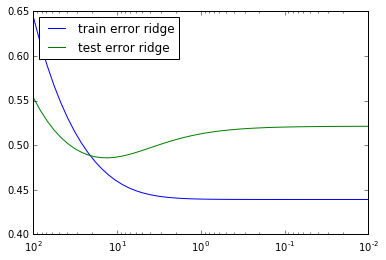

El error minimo se encuentra en alpha = 2.20307927232


In [26]:
Xtest = X[np.logical_not(istrain)]
ytest = y[np.logical_not(istrain)]
alphas_ = np.logspace(2,-2,base=10)
coefs = []
model = Ridge(fit_intercept=True)
mse_test = []
mse_train = []

for a in alphas_:
    model.set_params(alpha=a)
    model.fit(Xtrain, ytrain)
    yhat_train = model.predict(Xtrain)
    yhat_test = model.predict(Xtest)
    mse_train.append(np.mean(np.power(yhat_train - ytrain, 2)))
    mse_test.append(np.mean(np.power(yhat_test - ytest, 2)))

ax = plt.gca()
ax.plot(alphas_,mse_train,label='train error ridge')
ax.plot(alphas_,mse_test,label='test error ridge')
plt.legend(loc=2)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
plt.show()

print "El error minimo se encuentra en alpha =", min(zip(mse_test, yhat_test))[1]

El error de entrenamiento de Ridge es menor a medida que disminuye el alpha (más variables son consideradas) producto, probablemente, del sobre ajuste. Mientras tanto el error en el conjunto de prueba encuentra su optimo en un punto (en este caso en alpha igual a 2.2) lo que hace latente la necesidad de usar técnicas como cross-validation para empíricamente tener una mejor intuición de cuales son los parámetros óptimos.

(d) Utilizando "Lasso", construya un gráfico que muestre el error de entrenamiento y el error de pruebas como función del parámetro de regularización. Discuta lo que observa.

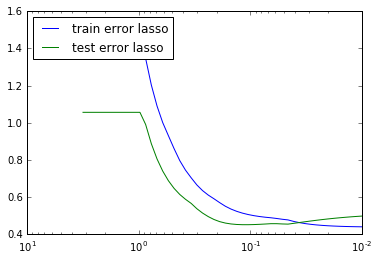

In [27]:
Xtest = X[np.logical_not(istrain)]
ytest = y[np.logical_not(istrain)]
alphas_ = np.logspace(0.5,-2,base=10)
coefs = []
model = Lasso(fit_intercept=True)
mse_test = []
mse_train = []

for a in alphas_:
    model.set_params(alpha=a)
    model.fit(Xtrain, ytrain)
    yhat_train = model.predict(Xtrain)
    yhat_test = model.predict(Xtest)
    mse_train.append(np.mean(np.power(yhat_train - ytrain, 2)))
    mse_test.append(np.mean(np.power(yhat_test - ytest, 2)))

ax = plt.gca()
ax.plot(alphas_,mse_train,label='train error lasso')
ax.plot(alphas_,mse_test,label='test error lasso')
plt.legend(loc=2)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
plt.show()

Se observa lo mismo que el ejercicio anterior pero de forma más agresiva producto de lo discutido en la pregunta (b)

(e) Estime el valor del parámetro de regularización en los métodos anteriores usando validación cruzada.

In [28]:
def MSE(y,yhat): return np.mean(np.power(y-yhat,2))
Xm = Xtrain.as_matrix()
ym = ytrain.as_matrix()
k_fold = cross_validation.KFold(len(Xm),10)
best_cv_mse = float("inf")
model = Lasso(fit_intercept=True)

for a in alphas_:
    model.set_params(alpha=a)
    mse_list_k10 = [MSE(model.fit(Xm[train], ym[train]).predict(Xm[val]), ym[val]) \
    for train, val in k_fold]
    if np.mean(mse_list_k10) < best_cv_mse:
        best_cv_mse = np.mean(mse_list_k10)
        best_alpha = a

print "BEST PARAMETER=%f, MSE(CV)=%f"%(best_alpha,best_cv_mse)

BEST PARAMETER=0.010000, MSE(CV)=0.758661
